# Best Speech Classifier

In the last notebook [Speech-Classifier-02.ipynb](Speech-Classifier-02.ipynb), we compared classifiers that are optimized for the `profit_score` function. Here we would like to serialze the model so that it's ready for combining decision.

## Load Data

Load data based on best possible combination from last document.

In [6]:
# load data b
import pandas as pd

feature_column = pd.read_csv("../Data/speech_data/indixes_speech.csv")['RForSVM'][1:]
train_data = pd.read_csv("../Data/speech_data/speech_train_set.csv")
val_data = pd.read_csv("../Data/speech_data/speech_validation_set.csv")
test_data = pd.read_csv("../Data/speech_data/speech_test_set.csv")

### Undersample 

Shuffle and undersample

In [7]:
# Shuffle
train_data = train_data.sample(frac=1, random_state=0)
# Undersampling
non_speech = train_data[train_data['class'] == 0]
speech = train_data[train_data['class'] == 1][:len(train_data[train_data['class'] == 0])]
dataset_train = speech.append(non_speech, ignore_index=True).sample(frac=1, random_state=0)

### Split data

Split into train, validatin, test.

In [8]:
X_train, y_train = train_data[feature_column], train_data['class']
X_val, y_val = val_data[feature_column], val_data['class']
X_test, y_test = test_data[feature_column], test_data['class']

## Training

Fit the model and evaluate other metrics

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
import handsomUtility

classifier = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                           max_depth=1000, max_features='auto', max_leaf_nodes=None,
                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                           min_samples_leaf=2, min_samples_split=6,
                                           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                                           oob_score=False, random_state=0, verbose=0, warm_start=False)

classifier.fit(X_train, y_train)
y_pred = handsomUtility.post_processing(classifier.predict(X_val.values))

Confusion Matrix: [0.52477931 0.01340134 0.02883548 0.43298387]
Accuracy: 0.9577631801840802
Actual Profit (after learning): 29560.200000015247


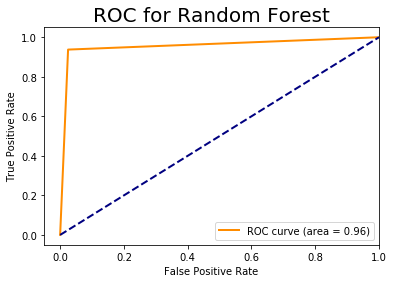

,accuracy,AUC,Actual Profit,Maximum Profit,TPR,FPR,FNR,TNR
Random Forest,0.957763,0.95633,29560.2,34156.2,0.524779,0.0134013,0.0288355,0.432984


In [46]:
accuracy = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred).ravel()/len(y_pred)
print("Confusion Matrix: {}".format(cm))
print("Accuracy: {}".format(accuracy_score(y_val, y_pred)))
print("Actual Profit (after learning): {}".format(handsomUtility.profit_score(y_val, y_pred)))
auc = handsomUtility.plotROC(y_val, y_pred, "Random Forest")
results = {'Accuracy': accuracy, 'AUC': auc, 'Actual Profit': handsomUtility.profit_score(y_val, y_pred), 'Maximum Profit': handsomUtility.profit_score(y_pred, y_pred), 'TPR':cm[0], 'FPR':cm[1], 'FNR':cm[2], 'TNR':cm[3]}
pd.DataFrame.from_dict(results, orient="index", columns=['Random Forest']).T.style.set_caption("Random Forest (RForSVM)")

## Serialization

Serialize the classifier so that we keep the weights.

In [49]:
import pickle
with open('../SpeechClassifier/best-speech-classifier.pkl', 'wb') as dump_file:
    pickle.dump()
    pickle.dump(classifier, dump_file) 

To load, use

In [69]:
y_pred_2 = handsomUtility.post_processing(classifier_2.predict(X_val.values))
print(np.vstack((y_pred, y_pred_2)).T)

[[1. 1.]
 [1. 1.]
 [1. 1.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


## Post Processing Comparison

Here we'll explore the difference before and after post-processing.

In [53]:
import handsomUtility
import numpy as np
import matplotlib.pyplot as plt
from seaborn import countplot
from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [11]:
y_pred_before = classifier.predict(X_val)
y_pred_after = handsomUtility.post_processing(classifier.predict(X_val))

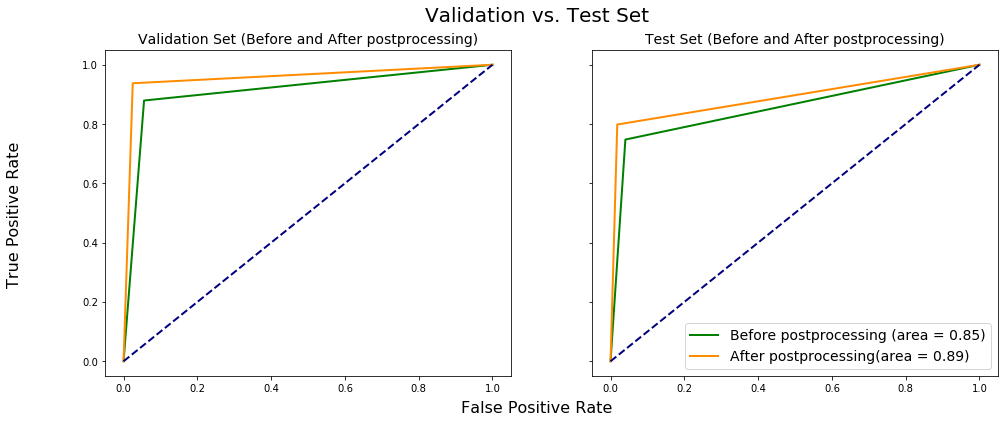

In [94]:
# plot roc curves
# construct two horizontal subplots, sharing the same axis
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 6))
# validation set
fpr, tpr, _ = roc_curve(y_val, y_pred_before)
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='green', lw=2, label='Before postprocessing (area = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(y_val, y_pred_after)
roc_auc = auc(fpr, tpr)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='After postprocessing(area = %0.2f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[0].set_title("Validation Set (Before and After postprocessing)", fontsize=14)
# Test Set
y_tred_before = classifier.predict(X_test)
y_tred_after = handsomUtility.post_processing(classifier.predict(X_test))
fpr, tpr, _ = roc_curve(y_test, y_tred_before)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='green', lw=2, label='Before postprocessing (area = %0.2f)' % roc_auc)
fpr, tpr, _ = roc_curve(y_test, y_tred_after)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='After postprocessing(area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_title("Test Set (Before and After postprocessing)", fontsize=14)

fig.suptitle("Validation vs. Test Set", fontsize=20)
# add common x and y labels
fig.text(0.5, 0.04, 'False Positive Rate', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'True Positive Rate', va='center', rotation='vertical', fontsize=16)
plt.legend(fontsize=14)
fig.savefig("../Visualization/ROC-validation-vs-testset.png")

<br><br><br>

----
<br><br><br>

## For the Presentation

Here I would just like to produce the plot for the presentation

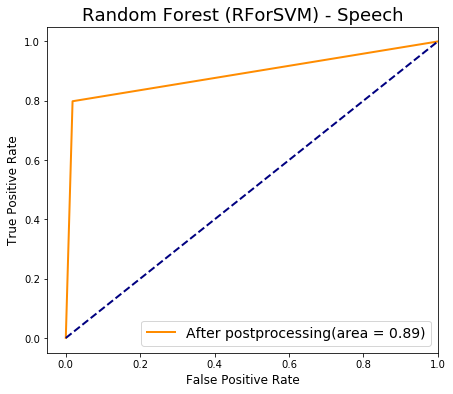

In [42]:
plt.figure(figsize=(7, 6))
fpr, tpr, _ = roc_curve(y_test, y_tred_after)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='After postprocessing(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title("Random Forest (RForSVM) - Speech", fontsize=18)
plt.legend(fontsize=14)
plt.savefig("../Visualization/ROC-for-best-speech-classifier-for-presenation.png")

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix
test_accuracy = accuracy_score(y_test, y_tred_after)
test_profit = handsomUtility.profit_score(y_test, y_tred_after)
max_test_profit = handsomUtility.profit_score(y_test, y_test)
test_cm = confusion_matrix()
print("Test Accuracy", accuracy, "\nTest Profit", test_profit, "/ Max Profit", max_test_profit, " = Precentage", test_profit/max_test_profit)

Test Accuracy 0.9292384924882803 
Test Profit 34301.20000000388 / Max Profit 41753.19999999707  = Precentage 0.8215226617362571


Normalized confusion matrix
[[0.98183512 0.01816488]
 [0.20159629 0.79840371]]


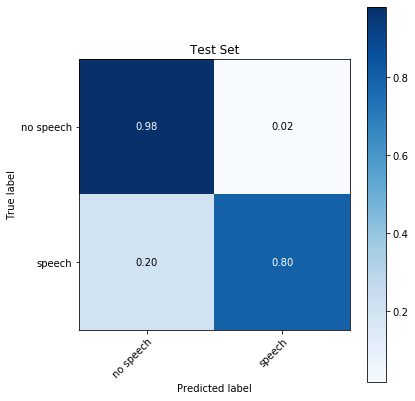

In [98]:
plot_confusion_matrix(y_test, y_tred_after, classes=np.array(["no speech", "speech"]), normalize=True, title="Test Set")

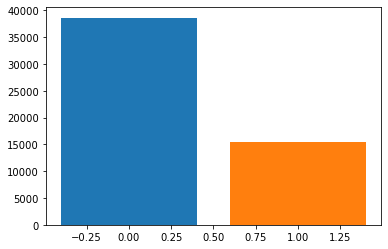

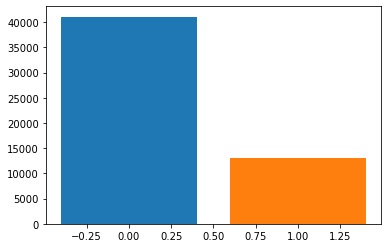

In [95]:
plt.bar(y_test[y_test==0], len(y_test[y_test==0]))
plt.bar(y_test[y_test==1], len(y_test[y_test==1]))
plt.show()
plt.bar(y_tred_after[y_tred_after==0], len(y_tred_after[y_tred_after==0]))
plt.bar(y_tred_after[y_tred_after==1], len(y_tred_after[y_tred_after==1]))
plt.show()

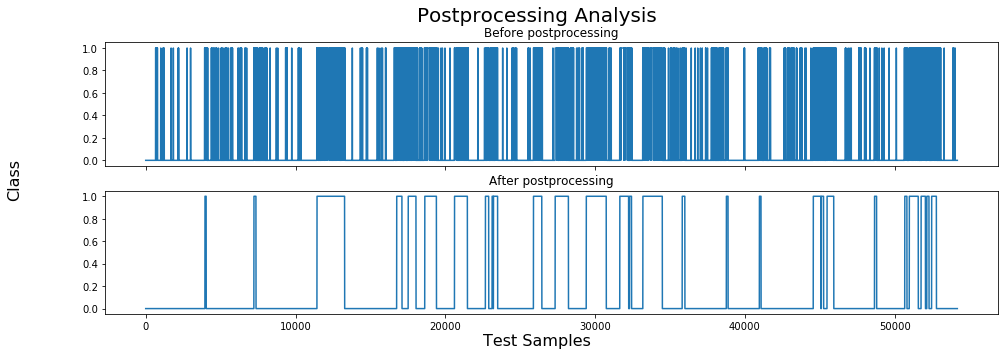

In [117]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 5))
ax[0].plot(y_tred_before)
ax[0].set_title("Before postprocessing")
ax[1].plot(y_tred_after)
ax[1].set_title("After postprocessing")
fig.suptitle("Postprocessing Analysis", fontsize=20)
fig.text(0.5, 0.04, 'Test Samples', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Class', va='center', rotation='vertical', fontsize=16)
fig.savefig("../Visualization/postprocessing-effect.png", dpi=300)
plt.show()